In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import warnings

# 경고 메시지 숨기기
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("./data/final_data.csv")
df.head()

,city,bd,gender,registered_via,is_churn,payment_plan_sum,plan_list_price,actual_amount_paid,discount_rate,is_auto_renew,...,transaction_count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,registration_duration,listening_duration
0,4,30,1,9,0,603,2980,3129,0.0,1.0,...,21,77,22,16,44,658,287,171508.646,2070,781
1,5,34,1,9,1,360,1072,1072,0.0,0.0,...,2,145,84,58,42,1678,1158,448313.054,2168,220
2,13,63,1,9,0,783,3874,4023,0.0,1.0,...,27,1173,390,246,308,5003,5784,1435958.164,2047,817
3,4,28,0,9,0,270,1589,1738,0.0,0.9,...,10,81,20,12,16,438,343,107171.103,2021,761
4,22,38,0,9,0,784,3874,4023,0.0,1.0,...,27,711,528,246,218,1129,2593,419622.336,2020,818


### EDA 할 컬럼
1. `아이디별 평균 할인률 (5,6번 컬럼 이용)`
2. `is_auto_renew (자동 갱신 비율)`
3. `membership_expire_date(아이디별 가장 마지막 날짜)`
4. `is_cancle (비율)`
5. `거래 횟수 (아이디별 count)`

* 타켓 컬럼 : `is_churn` 이탈 여부

#### is_churn 분포 확인

In [4]:
count_churn = df[df["is_churn"] == 1]
count_not_churn = df[df["is_churn"] == 0]

print(f"이탈한 고객 수 : {count_churn.shape[0]}, 이탈하지 않은 고객 수:{count_not_churn.shape[0]}")

이탈한 고객 수 : 62474, 이탈하지 않은 고객 수:293803


#### 상관분석

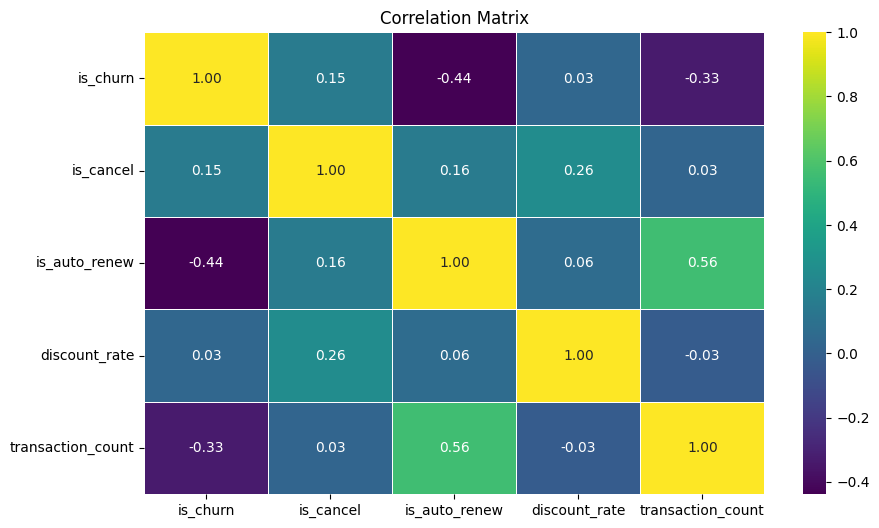

In [6]:
# 분석할 변수 선택
corr_columns = ['is_churn', 'is_cancel', 'is_auto_renew', 'discount_rate', 'transaction_count']

# 상관 행렬 계산
corr_matrix = df[corr_columns].corr()

# 히트맵 그리기
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5)

# 제목 추가
plt.title("Correlation Matrix")
plt.show()

* `is_cancel`, `is_auto_renew`, `transaction_count`의 경우 타겟 변수와 어느정도 상관관계를 보임.

#### 할인율에 따른 이탈여부

* y축 조정

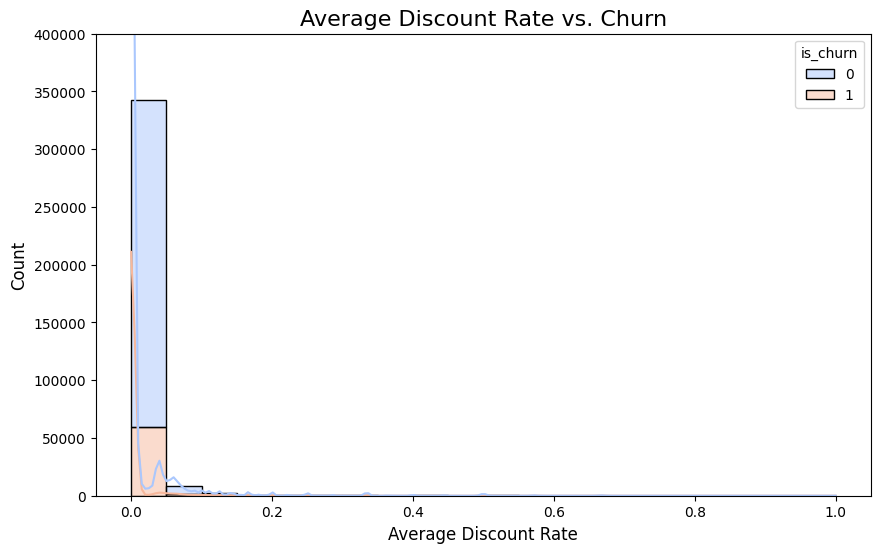

In [10]:

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='discount_rate', hue='is_churn', kde=True, bins=20, 
             palette="coolwarm", multiple="stack")

plt.ylim(0, 0.4e6)  # y축 최대값을 1e6(100만)으로 제한
plt.title("Average Discount Rate vs. Churn", fontsize=16)
plt.xlabel("Average Discount Rate", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

* 할인율이 0에서 0.1 사이인 구간에 고객이 몰려있는 것을 알 수 있음
* 이탈여부에 따라 할인율이 0에서 0.1사이 구간인 고객과 나머지 고객의 비율이 어떻게 되는지 알아보자

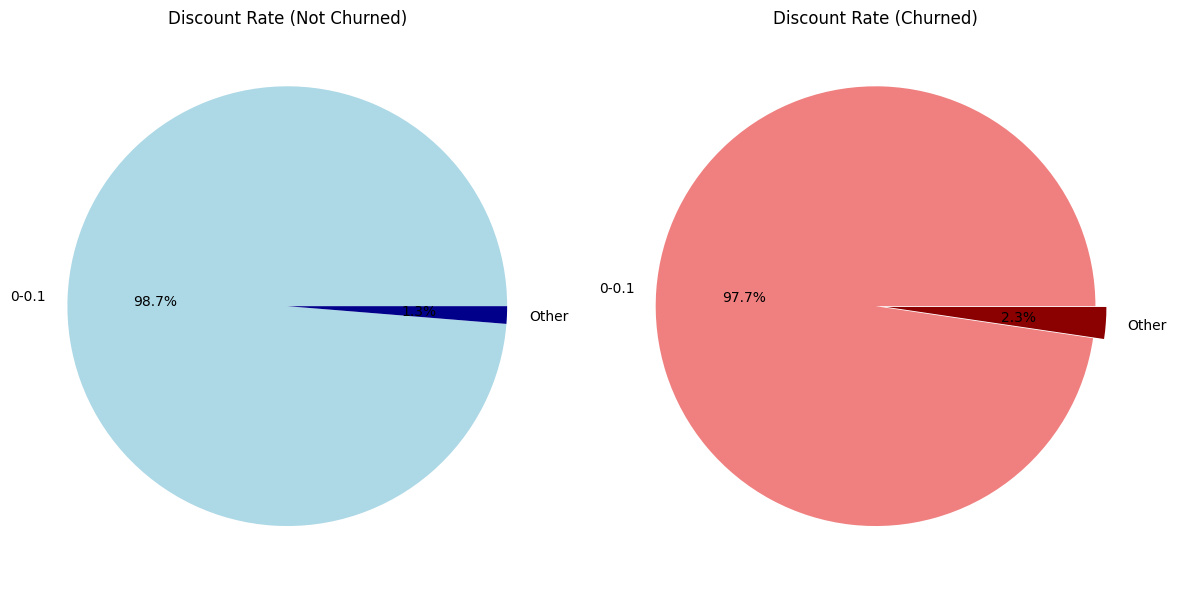

In [12]:

# 할인율 0~0.1 구간 여부 컬럼 생성
df['discount_rate_bin'] = df['discount_rate'].apply(lambda x: '0-0.1' if 0 <= x <= 0.1 else 'Other')

# is_churn 값에 따라 비율 계산
churn_0 = df[df['is_churn'] == 0]['discount_rate_bin'].value_counts(normalize=True)
churn_1 = df[df['is_churn'] == 1]['discount_rate_bin'].value_counts(normalize=True)

# 정렬 보장
churn_0 = churn_0.sort_index()
churn_1 = churn_1.sort_index()

# 원형 그래프 그리기
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 이탈 X (is_churn == 0)
axes[0].pie(churn_0, labels=churn_0.index, autopct='%1.1f%%', colors=['lightblue', 'darkblue'])
axes[0].set_title("Discount Rate (Not Churned)")

# # 이탈 O (is_churn == 1)
# axes[1].pie(churn_1, labels=churn_1.index, autopct='%1.1f%%', colors=['lightcoral', 'darkred'])
# axes[1].set_title("Discount Rate (Churned)")
# 'Others'가 있는 경우 해당 항목을 강조
# 'Others'가 있는 경우 해당 항목을 강조하기 위한 explode 리스트 생성
explode_values = [0] * len(churn_1)  # 모든 항목에 대해 기본값 0 설정

if 'Other' in churn_1.index:
    explode_values[churn_1.index.get_loc('Other')] = 0.05  # 'Other' 항목만 강조

# 파이 차트 그리기
axes[1].pie(churn_1, labels=churn_1.index, autopct='%1.1f%%', 
            colors=['lightcoral', 'darkred'], explode=explode_values)
axes[1].set_title("Discount Rate (Churned)")

plt.tight_layout()
plt.show()

### 자동 갱신 여부에 따른 이탈 여부 (리드미에 사용!)

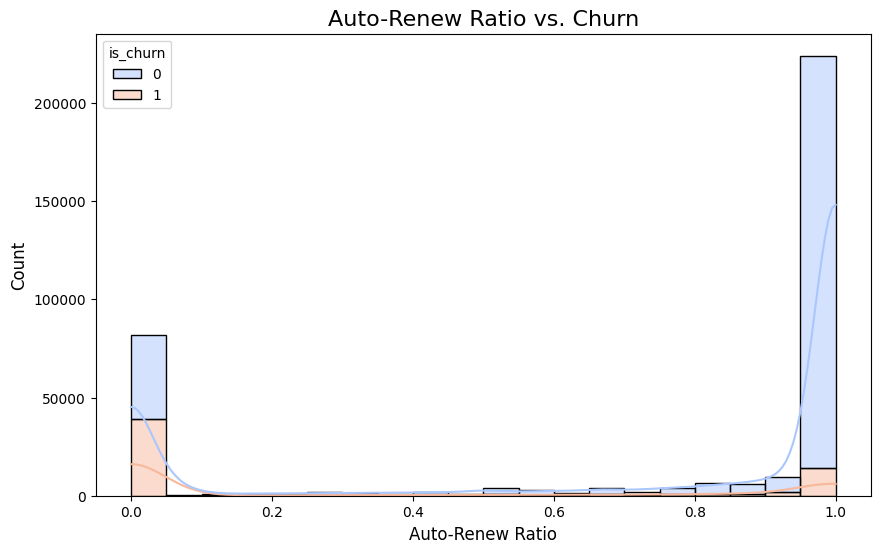

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='is_auto_renew', hue='is_churn', kde=True, bins=20, palette="coolwarm", multiple="stack")
plt.title("Auto-Renew Ratio vs. Churn", fontsize=16)
plt.xlabel("Auto-Renew Ratio", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()


* 자동 갱신 비율이 0(비자동 갱신)과 1(자동 갱신)일 때 데이터가 몰려 있음
    * 즉, 대부분의 고객이 자동 갱신을 계속 사용하거나 계속 사용하지 않거나 둘 중 하나임.
* 자동 갱신을 사용하지 않는 고객(0.0 부근)에서 주황색(이탈 고객)이 더 많이 보임.
    * 즉, 자동 갱신을 사용하지 않는 고객이 이탈할 확률이 더 높고, 자동 갱신을 사용할 경우 이탈률이 상대적으로 낮음.

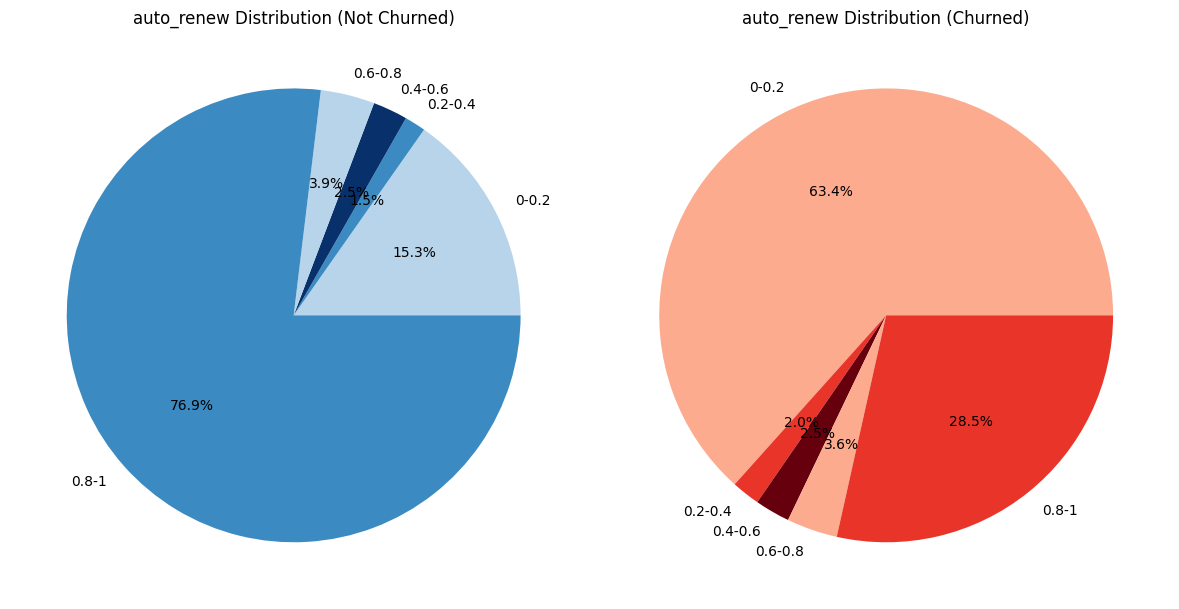

In [14]:
# Discount Rate 구간 정의
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1']

# 각 데이터에 해당 구간을 추가
df['is_auto_renew_bin'] = pd.cut(df['is_auto_renew'], bins=bins, labels=labels, include_lowest=True)

# is_churn 값에 따라 그룹화하여 비율 계산
churn_0 = df[df['is_churn'] == 0]['is_auto_renew_bin'].value_counts(normalize=True)
churn_1 = df[df['is_churn'] == 1]['is_auto_renew_bin'].value_counts(normalize=True)

# 정렬 보장
churn_0 = churn_0.sort_index()
churn_1 = churn_1.sort_index()

# 원형 그래프 그리기
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 이탈 X (is_churn == 0)
axes[0].pie(churn_0, labels=churn_0.index, autopct='%1.1f%%', colors=plt.cm.Blues(np.linspace(0.3, 1, 3)))
axes[0].set_title("auto_renew Distribution (Not Churned)")

# 이탈 O (is_churn == 1)
axes[1].pie(churn_1, labels=churn_1.index, autopct='%1.1f%%', colors=plt.cm.Reds(np.linspace(0.3, 1, 3)))
axes[1].set_title("auto_renew Distribution (Churned)")

plt.tight_layout()
plt.show()


* 이탈하지 않은 고객의 경우 자동갱신을 하는 고객 (0.8-1사이)가 85%이상을 차지하지만 반대로 이탈한 고객은 자동갱신을 거의 하지 않은 고객 (0-0.2사이)이 50% 이상으로 많은 비율을 차지
    *  고객이 자동 갱신을 활성화하도록 유도하는 전략이 중요할 것!

#### 구독 취소 비율에 따른 이탈 여부

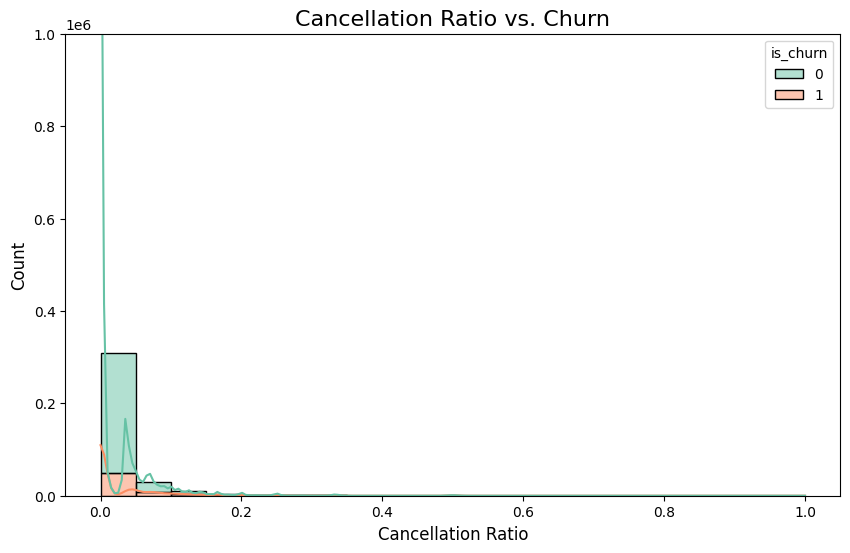

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='is_cancel', hue='is_churn', kde=True, bins=20, palette="Set2", multiple="stack")
plt.title("Cancellation Ratio vs. Churn", fontsize=16)
plt.xlabel("Cancellation Ratio", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.ylim(0, 1e6)
plt.show()



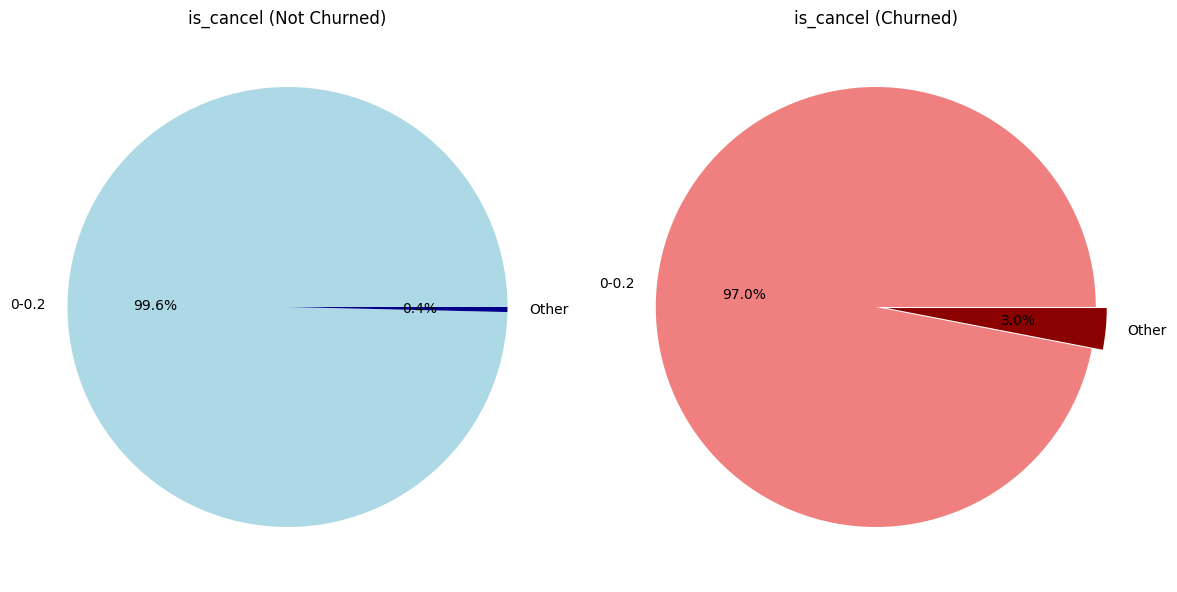

In [16]:

# 할인율 0~0.1 구간 여부 컬럼 생성
df['is_cancel_bin'] = df['is_cancel'].apply(lambda x: '0-0.2' if 0 <= x <= 0.2 else 'Other')

# is_churn 값에 따라 비율 계산
churn_0 = df[df['is_churn'] == 0]['is_cancel_bin'].value_counts(normalize=True)
churn_1 = df[df['is_churn'] == 1]['is_cancel_bin'].value_counts(normalize=True)

# 정렬 보장
churn_0 = churn_0.sort_index()
churn_1 = churn_1.sort_index()

# 원형 그래프 그리기
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 이탈 X (is_churn == 0)
axes[0].pie(churn_0, labels=churn_0.index, autopct='%1.1f%%', colors=['lightblue', 'darkblue'])
axes[0].set_title("is_cancel (Not Churned)")

# # 이탈 O (is_churn == 1)
# explode_values = [0, 1] if 'Others' in churn_1.index else [0, 0]  # Others 조각만 강조
# axes[1].pie(churn_1, labels=churn_1.index, autopct='%1.1f%%', colors=['lightcoral', 'darkred'], explode=explode_values)
# axes[1].set_title("is_cancel (Churned)")
# 이탈 O (is_churn == 1)
explode_values = [0, 0]  # 기본값은 둘 다 0으로 설정

# 'Others'가 있는 경우 해당 항목을 강조
if 'Other' in churn_1.index:
    explode_values[churn_1.index.get_loc('Other')] = 0.05  # 'Other' 항목만 강조

axes[1].pie(churn_1, labels=churn_1.index, autopct='%1.1f%%', colors=['lightcoral', 'darkred'], explode=explode_values)
axes[1].set_title("is_cancel (Churned)")
plt.tight_layout()
plt.show()

* 이탈한 사람들의 경우 구독 취소 후 다시 거래한 사람들의 비율이 약 3% 가량 높다.
* 이탈하지 않은 사람들은 0.3%를 제외한 나머지 사람들이 대부분 구독 취소를 하지 않는 다는 것을 확인

#### 구독 거래 횟수에 따른 이탈 여부 (리드미에 사용!)

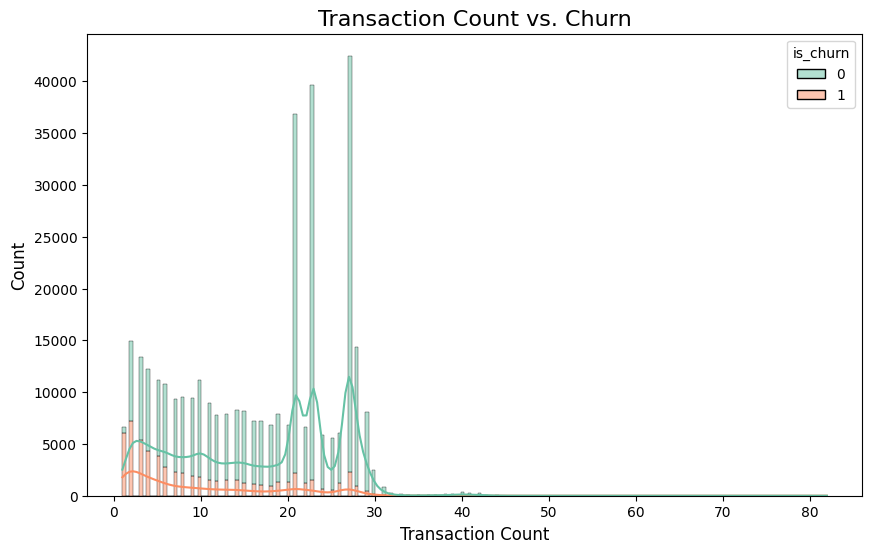

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(df, x='transaction_count', hue='is_churn', kde=True, multiple="stack", palette="Set2")
plt.title("Transaction Count vs. Churn", fontsize=16)
plt.xlabel("Transaction Count", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()


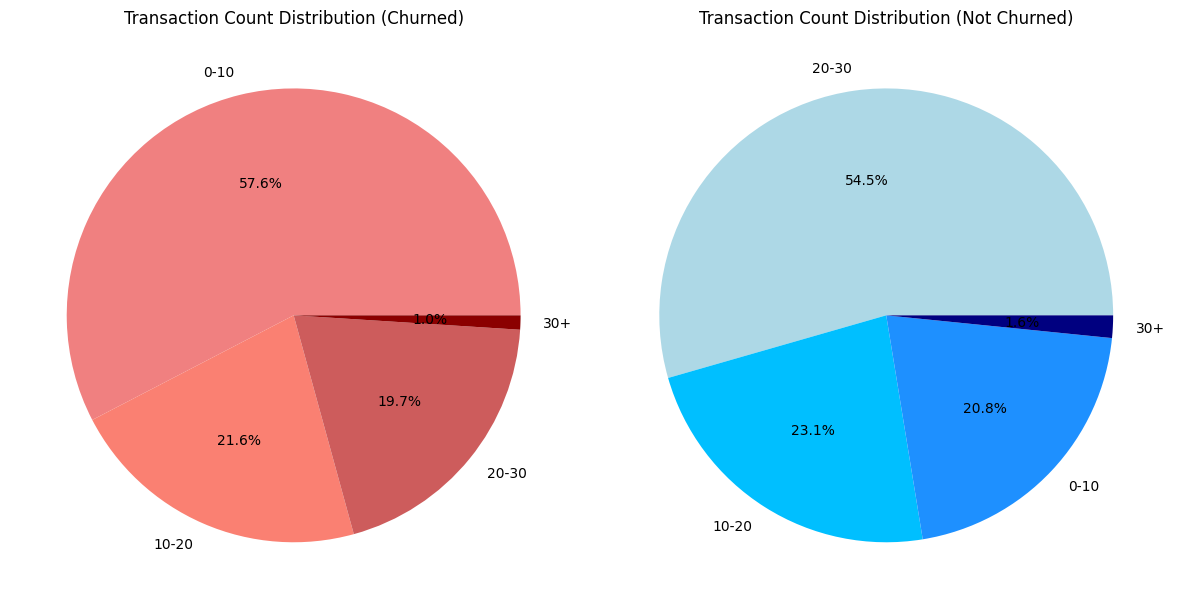

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# 거래 횟수 구간 설정
bins = [0, 10, 20, 30, df['transaction_count'].max()]
labels = ["0-10", "10-20", "20-30", "30+"]

# 거래 횟수 구간화
df['transaction_range'] = pd.cut(df['transaction_count'], bins=bins, labels=labels, right=False)

# 이탈한 고객과 이탈하지 않은 고객 분리
churned = df[df['is_churn'] == 1]['transaction_range'].value_counts(normalize=True)
not_churned = df[df['is_churn'] == 0]['transaction_range'].value_counts(normalize=True)

# 그래프 설정
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 이탈한 고객 원그래프
axes[0].pie(churned, labels=churned.index, autopct='%1.1f%%', colors=['lightcoral', 'salmon', 'indianred', 'darkred'])
axes[0].set_title("Transaction Count Distribution (Churned)")

# 이탈하지 않은 고객 원그래프
axes[1].pie(not_churned, labels=not_churned.index, autopct='%1.1f%%', colors=['lightblue', 'deepskyblue', 'dodgerblue', 'navy'])
axes[1].set_title("Transaction Count Distribution (Not Churned)")

# 레이아웃 조정
plt.tight_layout()
plt.show()


* 이탈한 사람들은 거래 횟수가 0-10사이에 가장 많이 분포하는데에 비해 이탈하지 않은 사람들은 20-30사이의 거래횟수에서 가장 많이 분포 한다. 
* 이탈한 사람들은 0-10 -> 10-20 -> 20-30 -> 30+순서로 비율이 많지만, 이탈하지 않은 사람들은 20-30 -> 10-20 -> 0-10 -> 30+순서로 비율이 많다.
    * 이탈하지 않은 사람들이 확실히 재구독을 한 경우가 많은 것을 알 수 있다.

#### 자동갱신과 구독취소 여부에 따른 이탈 비교

In [19]:

# 이탈 여부에 따라 데이터를 나누기
df_churn_0 = df[df['is_churn'] == 0]
df_churn_1 = df[df['is_churn'] == 1]

# 자동 갱신 비율과 구독 취소 비율을 계산
auto_renew_churn_0 = df_churn_0.groupby('is_auto_renew')['is_cancel'].mean().reset_index()
auto_renew_churn_1 = df_churn_1.groupby('is_auto_renew')['is_cancel'].mean().reset_index()


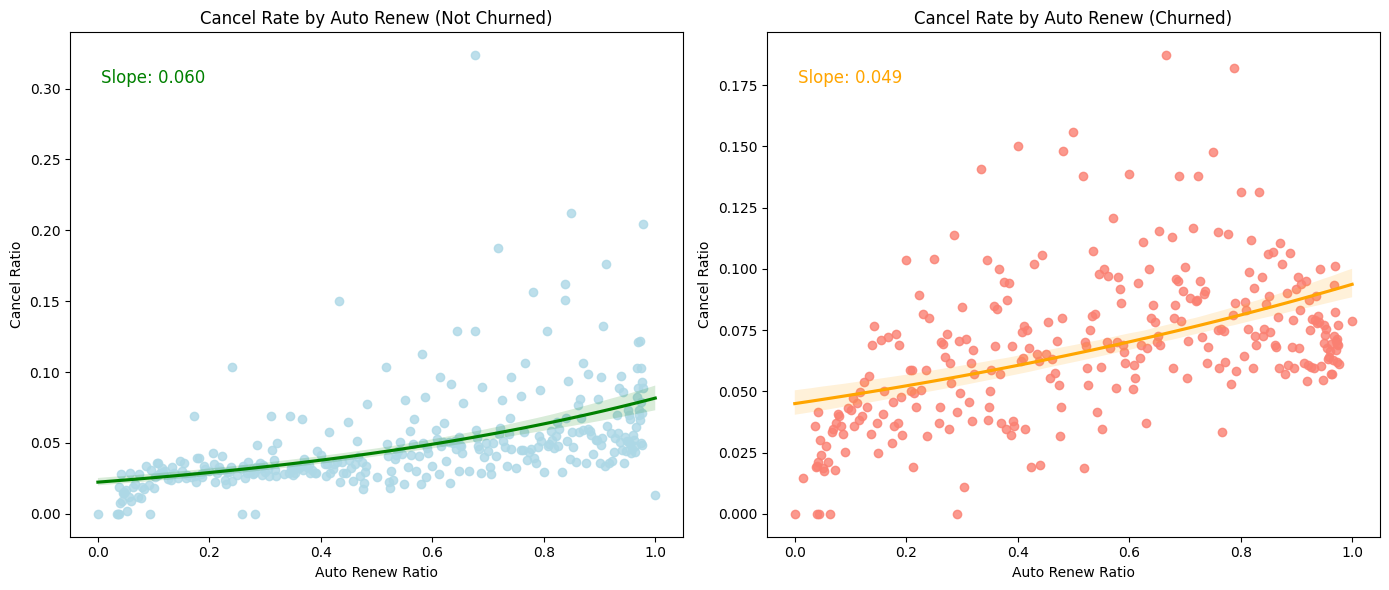

In [20]:

# 그래프 설정
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 이탈하지 않은 경우 (is_churn == 0) 자동 갱신 비율에 따른 구독 취소 비율
sns.regplot(data=auto_renew_churn_0, x='is_auto_renew', y='is_cancel', ax=axes[0], 
            scatter_kws={'color': 'lightblue'}, line_kws={'color': 'green'}, logistic=True)

# 이탈한 경우 (is_churn == 1) 자동 갱신 비율에 따른 구독 취소 비율
sns.regplot(data=auto_renew_churn_1, x='is_auto_renew', y='is_cancel', ax=axes[1], 
            scatter_kws={'color': 'salmon'}, line_kws={'color': 'orange'}, logistic=True)

# 기울기 계산 (이탈하지 않은 경우)
slope_0, intercept_0, r_value_0, p_value_0, std_err_0 = linregress(auto_renew_churn_0['is_auto_renew'], auto_renew_churn_0['is_cancel'])
# 기울기 계산 (이탈한 경우)
slope_1, intercept_1, r_value_1, p_value_1, std_err_1 = linregress(auto_renew_churn_1['is_auto_renew'], auto_renew_churn_1['is_cancel'])

# 기울기 출력
axes[0].text(0.05, 0.9, f'Slope: {slope_0:.3f}', transform=axes[0].transAxes, fontsize=12, color='green')
axes[1].text(0.05, 0.9, f'Slope: {slope_1:.3f}', transform=axes[1].transAxes, fontsize=12, color='orange')

# 제목 및 레이블 설정
axes[0].set_title("Cancel Rate by Auto Renew (Not Churned)")
axes[0].set_xlabel("Auto Renew Ratio")
axes[0].set_ylabel("Cancel Ratio")

axes[1].set_title("Cancel Rate by Auto Renew (Churned)")
axes[1].set_xlabel("Auto Renew Ratio")
axes[1].set_ylabel("Cancel Ratio")

# 레이아웃 조정
plt.tight_layout()
plt.show()

* 이탈여부와 관계없이 자동갱신 비율이 증가할 수록 구독 취소 비율이 증가한다,,,,?

### 구독 거래 기간과 이탈 여부 분석 (리드미 추가)

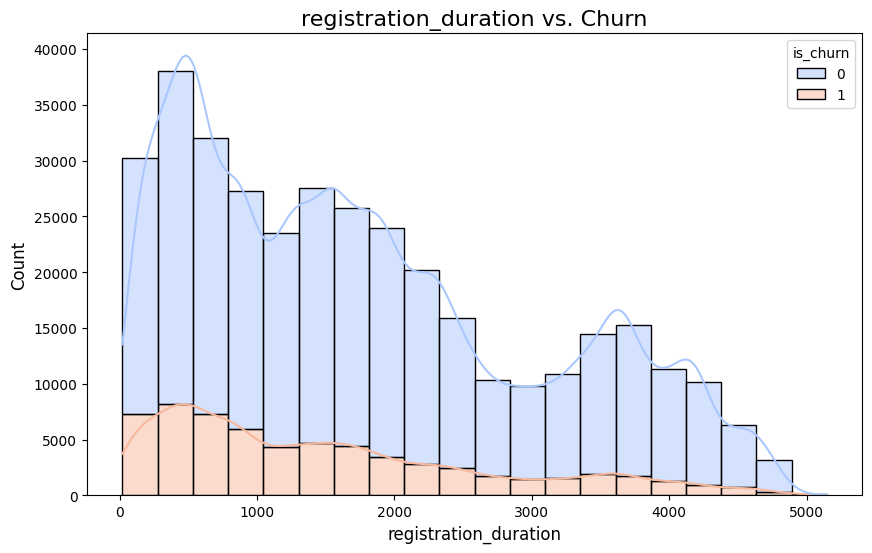

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='registration_duration', hue='is_churn', kde=True, bins=20, palette="coolwarm", multiple="stack")
plt.title("registration_duration vs. Churn", fontsize=16)
plt.xlabel("registration_duration", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

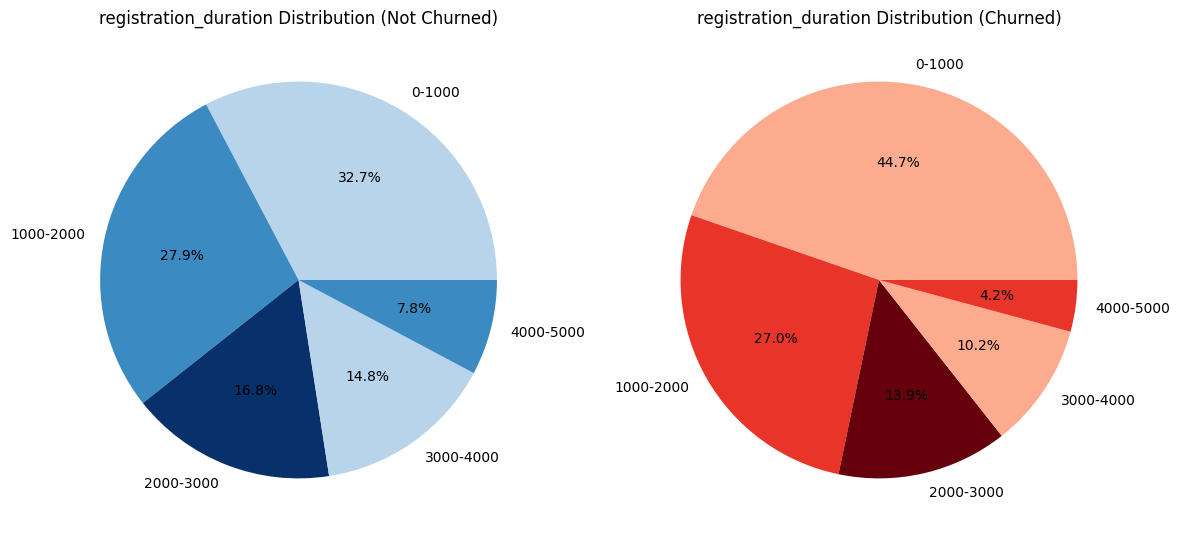

In [23]:
# Discount Rate 구간 정의
bins = [0, 1000, 2000, 3000, 4000, 5000]
labels = ['0-1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000']

# 각 데이터에 해당 구간을 추가
df['registration_duration_bin'] = pd.cut(df['registration_duration'], bins=bins, labels=labels, include_lowest=True)

# is_churn 값에 따라 그룹화하여 비율 계산
churn_0 = df[df['is_churn'] == 0]['registration_duration_bin'].value_counts(normalize=True)
churn_1 = df[df['is_churn'] == 1]['registration_duration_bin'].value_counts(normalize=True)

# 정렬 보장
churn_0 = churn_0.sort_index()
churn_1 = churn_1.sort_index()

# 원형 그래프 그리기
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 이탈 X (is_churn == 0)
axes[0].pie(churn_0, labels=churn_0.index, autopct='%1.1f%%', colors=plt.cm.Blues(np.linspace(0.3, 1, 3)))
axes[0].set_title("registration_duration Distribution (Not Churned)")

# 이탈 O (is_churn == 1)
axes[1].pie(churn_1, labels=churn_1.index, autopct='%1.1f%%', colors=plt.cm.Reds(np.linspace(0.3, 1, 3)))
axes[1].set_title("registration_duration Distribution (Churned)")

plt.tight_layout()
plt.show()

* 구독 거래 기간(일수)이 0-1000일 사이인 고객의 경우 이탈한 고객이 이탈하지 않은 고객에 비해 13%가량 높은 비율을 보인다.
    * 즉, 이탈한 고객은 구독 거래기간이 0-1000일로 짧은 경우가 많다는 것.
* 구독 거래 기간이 2000이상부터 이탈하지 않은 고객이 이탈한 고객에 비해 높은 비율을 가진다.

### 음악 청취 기간과 이탈 여부 분석 (리드미 추가)

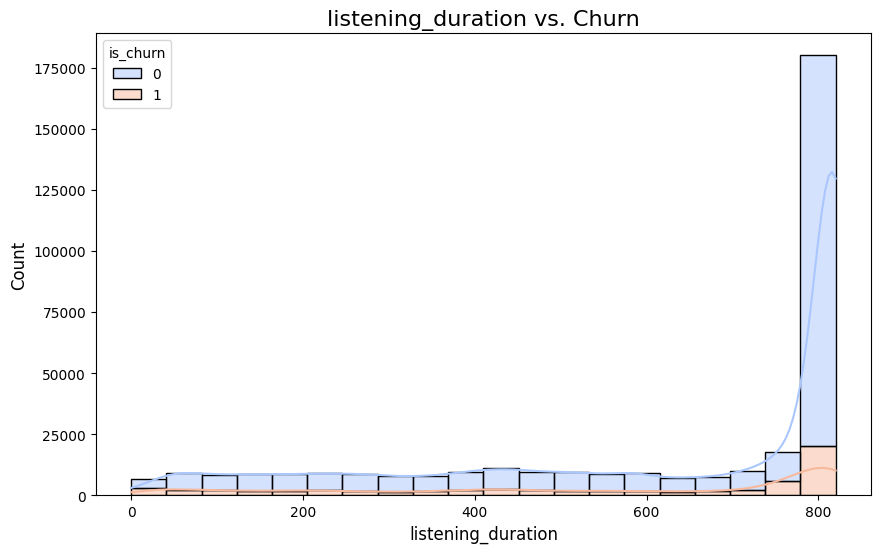

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='listening_duration', hue='is_churn', kde=True, bins=20, palette="coolwarm", multiple="stack")
plt.title("listening_duration vs. Churn", fontsize=16)
plt.xlabel("listening_duration", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

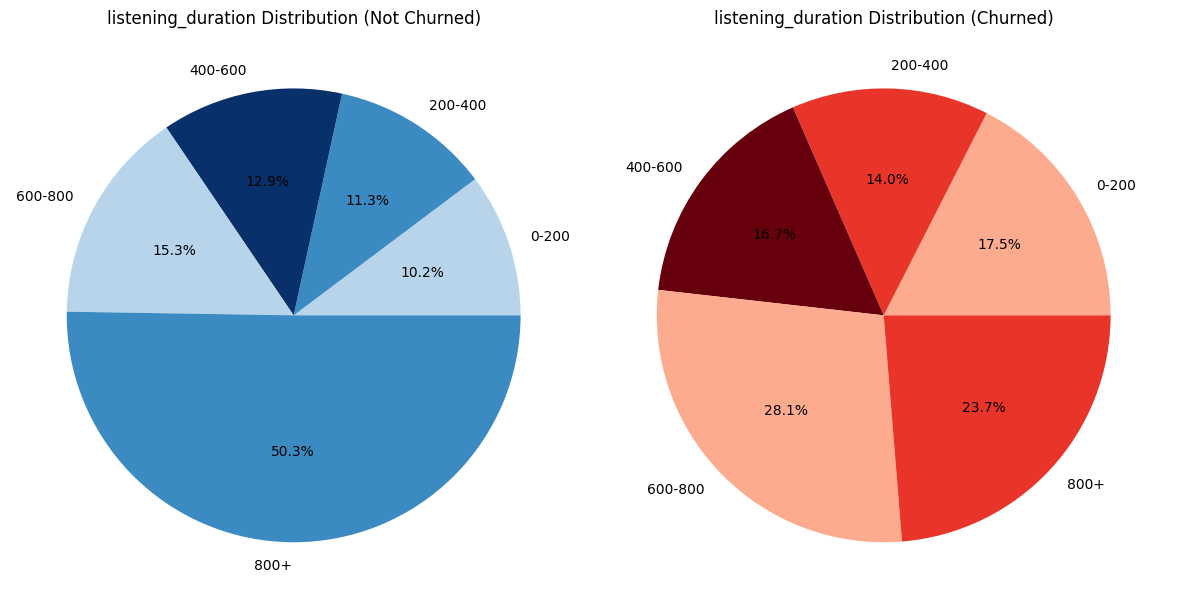

In [26]:
# Discount Rate 구간 정의
bins = [0, 200, 400, 600, 800, 1000]
labels = ['0-200', '200-400', '400-600', '600-800', '800+']

# 각 데이터에 해당 구간을 추가
df['listening_duration_bin'] = pd.cut(df['listening_duration'], bins=bins, labels=labels, include_lowest=True)

# is_churn 값에 따라 그룹화하여 비율 계산
churn_0 = df[df['is_churn'] == 0]['listening_duration_bin'].value_counts(normalize=True)
churn_1 = df[df['is_churn'] == 1]['listening_duration_bin'].value_counts(normalize=True)

# 정렬 보장
churn_0 = churn_0.sort_index()
churn_1 = churn_1.sort_index()

# 원형 그래프 그리기
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 이탈 X (is_churn == 0)
axes[0].pie(churn_0, labels=churn_0.index, autopct='%1.1f%%', colors=plt.cm.Blues(np.linspace(0.3, 1, 3)))
axes[0].set_title("listening_duration Distribution (Not Churned)")

# 이탈 O (is_churn == 1)
axes[1].pie(churn_1, labels=churn_1.index, autopct='%1.1f%%', colors=plt.cm.Reds(np.linspace(0.3, 1, 3)))
axes[1].set_title("listening_duration Distribution (Churned)")

plt.tight_layout()
plt.show()

* 이탈하지 않은 고객의 경우 800일 이상 음악을 청취한 경우가 50%이상으로 가장 많지만, 이탈한 고객은 600-800일 사이가 가장 많이 분포하고 있다.